In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os
import datetime

import urllib
import requests
import io
import json
import pylab as pl
import shapely
import shapely.wkt
from fiona.crs import from_epsg
import sys
from choropleth import choroplethNYC as cp
from censusAPI import myAPI

import statsmodels as sm
import statsmodels.formula.api as smf
import scipy as sp
from scipy import stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Download Eviction Data

- Un-comment cellblock below to download eviction data.

In [4]:
# !wget https://data.cityofnewyork.us/api/views/6z8x-wfk4/rows.csv?accessType=DOWNLOAD
# !mv rows.csv?accessType=DOWNLOAD $PUIDATA/evictions.csv

In [5]:
# reading in data
evics = pd.read_csv(os.getenv('PUIDATA') + '/evictions.csv')
evics.head()

,COURT_INDEX_NUMBER,DOCKET_NUMBER,EVICTION_ADDRESS,EVICTION_APT_NUM,EXECUTED_DATE,MARSHAL_FIRST_NAME,MARSHAL_LAST_NAME,RESIDENTIAL_COMMERCIAL_IND,BOROUGH,EVICTION_ZIP,SCHEDULE_STATUS
0,13113/16,202275,14-01 36TH AVENUE,06A,01/23/2018,Richard,Capuano,Residential,QUEENS,11106,Scheduled
1,59892/16,3565,240-09 WELLER AVENUE,NaN,02/27/2017,Edward,Guida,Residential,QUEENS,11422,Scheduled
2,77918/16,463866,65-09 99TH STREET,6T,02/21/2017,Danny,Weinheim,Residential,QUEENS,11374,Scheduled
3,K54594/17,82156,1360 HERKIMER STREET,NaN,01/25/2018,Ileana,Rivera,Residential,BROOKLYN,11233,Scheduled
4,801180/16,320809,2070 CLINTON AVE,12J,06/07/2017,John,Villanueva,Residential,BRONX,10457,Scheduled


In [6]:
evics.shape

(43705, 11)

In [7]:
# need to extract date, first turn into datetime object since it is just an object 
evics.EXECUTED_DATE = pd.to_datetime(evics.EXECUTED_DATE, errors='coerce')

In [8]:
# extracting year from date
evics['year'] = evics.EXECUTED_DATE.dt.year

In [9]:
# filter just 2017 evictions
evics17 = evics.loc[(evics.year == 2017)] #take only evictions in the year 2017

In [10]:
evics17.shape

(22524, 12)

In [11]:
len(evics17.EVICTION_ZIP.unique())
# number of unique zip codes

193

In [12]:
# grouping evictions by zipcode
evics17_a = evics17[['COURT_INDEX_NUMBER', 'EVICTION_ZIP']].groupby(by='EVICTION_ZIP').count()

In [13]:
# reseting index
evics_b = evics17_a.reset_index()

## Zipcode Shapefile

- To download zipcode shapefile for NYC, un-comment cellblock below.

In [14]:
# url='https://data.cityofnewyork.us/api/views/i8iw-xf4u/files' +\
# '/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip'
# urllib.request.urlretrieve(url, "file.gz")
# # unpacking into $PUIDATA
# !unzip file.gz -d $PUIDATA

In [15]:
# download NYC zipcode shapefile
nyczips = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/ZIP_CODE_040114.shp')
nyczips.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [16]:
nyczips.shape

(263, 13)

In [17]:
nyczips.ZIPCODE = nyczips.ZIPCODE.astype(int)

In [18]:
evic_geo = pd.merge(nyczips, evics_b, left_on='ZIPCODE', right_on='EVICTION_ZIP')

In [19]:
evic_geo.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,EVICTION_ZIP,COURT_INDEX_NUMBER
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,46
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,311
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,500
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,239
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,89


In [20]:
evic_geo.shape

(196, 15)

# Pluto Data

- To download PLUTO data, uncomment cellblock below.

In [21]:
#!curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_18v1.zip

In [22]:
#!unzip nyc_pluto_18v1.zip -d $PUIDATA

In [23]:
bk = pd.read_csv(os.getenv('PUIDATA') + '/PLUTO_for_WEB/BK_18v1.csv')
bx = pd.read_csv(os.getenv('PUIDATA') + '/PLUTO_for_WEB/BX_18v1.csv')
mn = pd.read_csv(os.getenv('PUIDATA') + '/PLUTO_for_WEB/MN_18v1.csv')
qn = pd.read_csv(os.getenv('PUIDATA') + '/PLUTO_for_WEB/QN_18v1.csv')
si = pd.read_csv(os.getenv('PUIDATA') + '/PLUTO_for_WEB/SI_18v1.csv')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20,22,23,24,25,26,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20,23,24,26,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/

In [24]:
bk2 = bk[['ZipCode', 'UnitsTotal']]
bx2 = bx[['ZipCode', 'UnitsTotal']]
mn2 = mn[['ZipCode', 'UnitsTotal']]
qn2 = qn[['ZipCode', 'UnitsTotal']]
si2 = si[['ZipCode', 'UnitsTotal']]

In [25]:
frames = [bk2, bx2, mn2, qn2, si2]
nycpluto = pd.concat(frames)

In [26]:
pluto_cts = nycpluto.groupby(by='ZipCode').sum()
pluto_cts2 = pluto_cts.reset_index()

# Merging with eviction + zipcode shapefile

In [27]:
evic_geo.ZIPCODE = evic_geo.ZIPCODE.astype(int)

In [28]:
## Merging with evic_geo
evic_pluto = pd.merge(evic_geo, pluto_cts2, left_on='ZIPCODE', right_on='ZipCode')
evic_pluto.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,EVICTION_ZIP,COURT_INDEX_NUMBER,ZipCode,UnitsTotal
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,46,11436.0,6168
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,311,11213.0,28069
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,500,11212.0,34301
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,239,11225.0,25872
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,89,11218.0,28777


# More cleaning

In [29]:
# only retaining columns of interest
evicR = evic_pluto[['ZIPCODE', 'POPULATION', 'COUNTY', 'geometry', 'COURT_INDEX_NUMBER', 'UnitsTotal']]

In [30]:
# renaming columns
cols = {'ZIPCODE':'zipcode', 'POPULATION':'pop', 'COUNTY':'county', 'geometry':'geometry', 'COURT_INDEX_NUMBER':'evictions',
       'UnitsTotal':'total_units'}
evicR.rename(index=str, columns=cols, inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [31]:
# creating ratio
evicR['evic_ratio'] = (evicR['evictions'] / evicR['total_units'])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [32]:
# creating percentage based on ratio since very small
evicR['evic_pct'] = evicR['evic_ratio'] * 100

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Removing values

- Removing zipcodes that have 0 population (there are three instances)
- Removing zipcodes that have total number of units less than 100 (this instance occurs also with population 0, so will be removed from exercise to remove 0 values in pop)

In [33]:
evicR.head()

,zipcode,pop,county,geometry,evictions,total_units,evic_ratio,evic_pct
0,11436,18681.0,Queens,"POLYGON ((1038098.251871482 188138.3800067157,...",46,6168,0.007458,0.745785
1,11213,62426.0,Kings,"POLYGON ((1001613.712964058 186926.4395172149,...",311,28069,0.011080,1.107984
2,11212,83866.0,Kings,"POLYGON ((1011174.275535807 183696.33770971, 1...",500,34301,0.014577,1.457683
3,11225,56527.0,Kings,"POLYGON ((995908.3654508889 183617.6128015518,...",239,25872,0.009238,0.923779
4,11218,72280.0,Kings,"POLYGON ((991997.1134308875 176307.4958601296,...",89,28777,0.003093,0.309275


In [34]:
# removes values where pop = 0
evicF = evicR[evicR['pop'] != 0]

In [35]:
print('The average eviction rate across all zipcodes is: ', evicF.evic_pct.mean())
print('The average number of buildings in each zipcode is: ', evicF.total_units.mean())
print('The average population in each zip is: ', evicF['pop'].mean())
print('The average number of evictions per zipcode is: ', evicF.evictions.mean())

The average eviction rate across all zipcodes is:  0.557813499348
The average number of buildings in each zipcode is:  20950.0366492
The average population in each zip is:  43908.6701571
The average number of evictions per zipcode is:  120.842931937


# Download income from ACS

In [36]:
url = "https://api.census.gov/data/2017/acs/acs5?get=" + 'B19013_001E' +\
",NAME&for=zip%20code%20tabulation%20area:*&key=" + myAPI
resp = requests.request('GET', url).content
total = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [37]:
acsinc = total[['B19013_001E', 'zip code tabulation area']]
acsinc2 = acsinc.rename(columns={'B19013_001E':'income', 'zip code tabulation area':'zipcode'})
acsinc2.head()

,income,zipcode
0,11757,601
1,16190,602
2,16645,603
3,13387,606
4,18741,610


In [38]:
acs17 = acsinc2.loc[(acsinc2.zipcode>=10000) & (acsinc2.zipcode<11500)] #take only NYC zip codes

There are weird strings in the income column (there was a '-' and a '250,000+'). I converted the '-' to Nan and dropped it. I converted the '250,000+' to 250,000. Finally, missing values were coded as '-66666', throwing the mean off. So, I set the income minimum to 500 to remove that and any 0 values.

In [39]:
acs17['income'].replace('-', np.nan, inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [40]:
acs17['income'].replace('250,000+', 250000, inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [41]:
acs17D = acs17.dropna(axis=1, how='all')

In [42]:
acs17D.income = acs17D.income.astype(float)

In [43]:
acs171 = acs17D.loc[(acs17D.income>500)]
acs171.shape

(314, 2)

# Merging income data with evictions df

In [44]:
evicFinal = evicF.merge(acs171, on='zipcode')
evicFinal.head()

,zipcode,pop,county,geometry,evictions,total_units,evic_ratio,evic_pct,income
0,11436,18681.0,Queens,"POLYGON ((1038098.251871482 188138.3800067157,...",46,6168,0.007458,0.745785,69259.0
1,11213,62426.0,Kings,"POLYGON ((1001613.712964058 186926.4395172149,...",311,28069,0.011080,1.107984,40604.0
2,11212,83866.0,Kings,"POLYGON ((1011174.275535807 183696.33770971, 1...",500,34301,0.014577,1.457683,25677.0
3,11225,56527.0,Kings,"POLYGON ((995908.3654508889 183617.6128015518,...",239,25872,0.009238,0.923779,51926.0
4,11218,72280.0,Kings,"POLYGON ((991997.1134308875 176307.4958601296,...",89,28777,0.003093,0.309275,64152.0


In [45]:
evicFinal['incpp'] = evicFinal['income'] / evicFinal['pop']
evicFinal.head()

,zipcode,pop,county,geometry,evictions,total_units,evic_ratio,evic_pct,income,incpp
0,11436,18681.0,Queens,"POLYGON ((1038098.251871482 188138.3800067157,...",46,6168,0.007458,0.745785,69259.0,3.707457
1,11213,62426.0,Kings,"POLYGON ((1001613.712964058 186926.4395172149,...",311,28069,0.011080,1.107984,40604.0,0.650434
2,11212,83866.0,Kings,"POLYGON ((1011174.275535807 183696.33770971, 1...",500,34301,0.014577,1.457683,25677.0,0.306167
3,11225,56527.0,Kings,"POLYGON ((995908.3654508889 183617.6128015518,...",239,25872,0.009238,0.923779,51926.0,0.918605
4,11218,72280.0,Kings,"POLYGON ((991997.1134308875 176307.4958601296,...",89,28777,0.003093,0.309275,64152.0,0.887548


(None,
 <matplotlib.legend.Legend at 0x7fe2ed507278>)

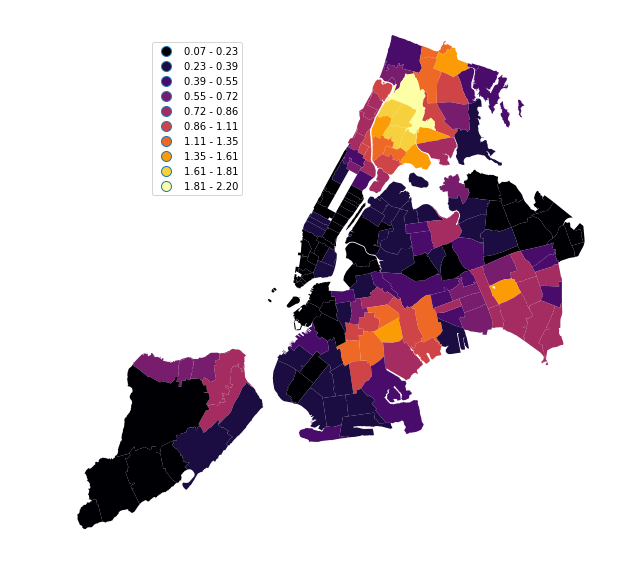

In [46]:
cp(evicFinal, column='evic_pct', cmap='inferno', scheme='fisher_jenks')

# Reading in litigation data

In [47]:
#!wget https://data.cityofnewyork.us/api/views/59kj-x8nc/rows.csv?accessType=DOWNLOAD

In [48]:
# moving to puidata
#!mv rows.csv?accessType=DOWNLOAD $PUIDATA/litigations.csv

In [49]:
# reading in data
litigations = pd.read_csv(os.getenv('PUIDATA') + '/litigations.csv')
litigations.head()

,LitigationID,BuildingID,Boro,HouseNumber,StreetName,Zip,Block,Lot,CaseType,CaseOpenDate,...,Penalty,Respondent,Latitude,Longitude,Community District,Council District,Census Tract,BIN,BBL,NTA
0,281964,344337,3,2501,NEWKIRK AVENUE,11226.0,5212,24,Comprehensive,05/18/2016 00:00:00,...,NaN,"ISAAC GUTMAN,NEWKIRK REALTY HOLDINGS 2501 LLC",40.639709,-73.953068,17.0,45.0,790.0,3120374.0,3.052120e+09,Erasmus
1,110512,42819,1,522,WEST 159 STREET,10032.0,2117,25,Heat and Hot Water,01/21/2010 00:00:00,...,NaN,"JONATHAN MALINAS,JUDICIAL REALTY",40.834461,-73.941967,12.0,7.0,245.0,1062759.0,1.021170e+09,Washington
2,147832,316541,3,199,JAVA STREET,11222.0,2541,41,Heat and Hot Water,01/25/2011 00:00:00,...,NaN,"EUGENE ACEVEDO,J. CADILLAC LLC",40.731788,-73.952751,1.0,33.0,575.0,3064494.0,3.025410e+09,Greenpoint
3,223576,81791,2,2250,GRAND CONCOURSE,10457.0,3158,14,Heat and Hot Water,10/25/2013 00:00:00,...,NaN,"2250 SUPERIOR APARTMENTS LLC,ABDUL KHAN,ANGELA...",40.856598,-73.900434,5.0,15.0,38301.0,2013721.0,2.031580e+09,Fordham So
4,129426,58354,2,480,CONCORD AVENUE,10455.0,2577,38,Access Warrant - Non-Lead,06/28/2010 00:00:00,...,NaN,480 CONCORD AVE OWNER LLC,40.811197,-73.908810,1.0,8.0,35.0,2003900.0,2.025770e+09,Mott Haven


In [50]:
litR = litigations[['Boro', 'Zip', 'CaseType', 'CaseOpenDate', 'Penalty', 'Latitude', 'Longitude', 
                           'Census Tract']]

In [51]:
litR['Coordinates'] = list(zip(litR.Longitude, litR.Latitude))
litR['Coordinates'] = litR['Coordinates'].apply(Point)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [52]:
litR['CaseOpenDate'] = pd.to_datetime(litR['CaseOpenDate'])
litR.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Boro,Zip,CaseType,CaseOpenDate,Penalty,Latitude,Longitude,Census Tract,Coordinates
0,3,11226.0,Comprehensive,2016-05-18,NaN,40.639709,-73.953068,790.0,POINT (-73.953068 40.639709)
1,1,10032.0,Heat and Hot Water,2010-01-21,NaN,40.834461,-73.941967,245.0,POINT (-73.94196700000001 40.834461)
2,3,11222.0,Heat and Hot Water,2011-01-25,NaN,40.731788,-73.952751,575.0,POINT (-73.95275100000001 40.731788)
3,2,10457.0,Heat and Hot Water,2013-10-25,NaN,40.856598,-73.900434,38301.0,POINT (-73.90043399999999 40.856598)
4,2,10455.0,Access Warrant - Non-Lead,2010-06-28,NaN,40.811197,-73.908810,35.0,POINT (-73.90881 40.811197)


In [53]:
# extracting year from date
litR['year'] = litR.CaseOpenDate.dt.year

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [54]:
litG = gpd.GeoDataFrame(litR, geometry='Coordinates')

In [55]:
litG.year.unique()

array([ 2016.,  2010.,  2011.,  2013.,  2015.,  2007.,  2014.,  2017.,
        2005.,  2006.,  2008.,  2009.,  2012.,    nan,  2004.,  2000.,
        2003.,  2018.])

In [56]:
# filter just 2017 lawsuits
lit17 = litG.loc[(litG.year == 2017)] 

In [57]:
lit17.crs = from_epsg(4326)
lit17.to_crs(epsg=2263, inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame[geo_column_name] = level


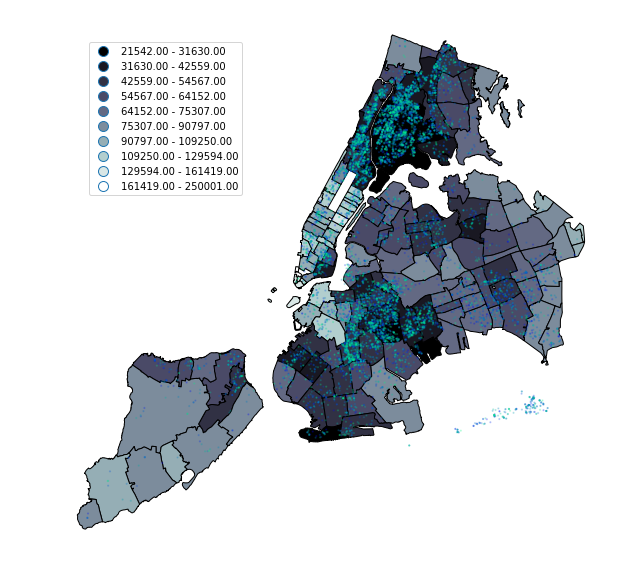

In [58]:
f = cp(evicFinal, column='income', cmap='bone', scheme='fisher_jenks', edgecolor='black')
lit17.plot(ax=f[1], marker='.', c="CaseOpenDate", 
             markersize=6, cmap="winter", alpha=0.2);

# Cleaning litigation data (some not all) to merge with eviction df

In [59]:
lit17.head()

,Boro,Zip,CaseType,CaseOpenDate,Penalty,Latitude,Longitude,Census Tract,Coordinates,year
17,2,10451.0,Tenant Action/Harrassment,2017-07-31,NaN,40.828783,-73.921617,18301.0,POINT (1005942.115771452 241234.9479270852),2017.0
21,4,11433.0,Heat and Hot Water,2017-04-26,NaN,40.698636,-73.779877,414.0,POINT (1045287.072209544 193885.0832622594),2017.0
28,3,11236.0,Tenant Action,2017-03-03,NaN,40.644186,-73.898452,988.0,POINT (1012430.880328382 173987.0429652454),2017.0
36,3,11207.0,Heat and Hot Water,2017-01-19,NaN,40.674884,-73.901487,1144.0,POINT (1011576.051198962 185170.2132816419),2017.0
39,3,11210.0,Heat and Hot Water,2017-02-15,NaN,40.625894,-73.940891,740.0,POINT (1000658.009569791 167311.9760382803),2017.0


In [60]:
lit17.shape

(12287, 10)

In [61]:
lit17R = lit17.groupby(by='Zip').count()

In [62]:
lit17R = lit17R.reset_index()

In [63]:
litF = lit17R[['Zip', 'year']]
litF.rename(columns={'Zip':'zipcode', 'year':'litigations'}, inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


# Merging with eviction df

In [64]:
evicFinal_ = evicFinal.merge(litF, on='zipcode')
evicFinal_.head()

,zipcode,pop,county,geometry,evictions,total_units,evic_ratio,evic_pct,income,incpp,litigations
0,11436,18681.0,Queens,"POLYGON ((1038098.251871482 188138.3800067157,...",46,6168,0.007458,0.745785,69259.0,3.707457,34
1,11213,62426.0,Kings,"POLYGON ((1001613.712964058 186926.4395172149,...",311,28069,0.011080,1.107984,40604.0,0.650434,248
2,11212,83866.0,Kings,"POLYGON ((1011174.275535807 183696.33770971, 1...",500,34301,0.014577,1.457683,25677.0,0.306167,237
3,11225,56527.0,Kings,"POLYGON ((995908.3654508889 183617.6128015518,...",239,25872,0.009238,0.923779,51926.0,0.918605,191
4,11218,72280.0,Kings,"POLYGON ((991997.1134308875 176307.4958601296,...",89,28777,0.003093,0.309275,64152.0,0.887548,53


In [65]:
evicFinal_.litigations.dtype

dtype('int64')

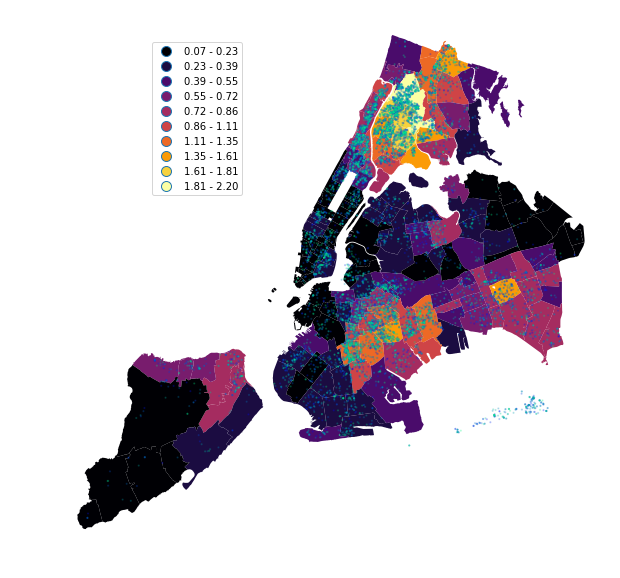

In [66]:
f = cp(evicFinal, column='evic_pct', cmap='inferno', scheme='fisher_jenks')
lit17.plot(ax=f[1], marker='.', c="CaseOpenDate", 
             markersize=6, cmap="winter", alpha=0.2);

In [67]:
evicFinal_['lit_pct'] = evicFinal_['litigations'] / evicFinal_['total_units'] * 100
#evicFinal_.drop(['litpp'], axis=1, inplace=True)

In [68]:
evicFinal_.head()

,zipcode,pop,county,geometry,evictions,total_units,evic_ratio,evic_pct,income,incpp,litigations,lit_pct
0,11436,18681.0,Queens,"POLYGON ((1038098.251871482 188138.3800067157,...",46,6168,0.007458,0.745785,69259.0,3.707457,34,0.551232
1,11213,62426.0,Kings,"POLYGON ((1001613.712964058 186926.4395172149,...",311,28069,0.011080,1.107984,40604.0,0.650434,248,0.883537
2,11212,83866.0,Kings,"POLYGON ((1011174.275535807 183696.33770971, 1...",500,34301,0.014577,1.457683,25677.0,0.306167,237,0.690942
3,11225,56527.0,Kings,"POLYGON ((995908.3654508889 183617.6128015518,...",239,25872,0.009238,0.923779,51926.0,0.918605,191,0.738250
4,11218,72280.0,Kings,"POLYGON ((991997.1134308875 176307.4958601296,...",89,28777,0.003093,0.309275,64152.0,0.887548,53,0.184175


In [69]:
evicFinal.shape

(183, 10)

# Add in non-white

- Adding race data

In [70]:
url = "https://api.census.gov/data/2017/acs/acs5?get=" + 'B02001_001E' +\
",NAME&for=zip%20code%20tabulation%20area:*&key=" + myAPI
resp = requests.request('GET', url).content
total = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [71]:
total.head()

,B02001_001E,NAME,zip code tabulation area,Unnamed: 3
0,345,ZCTA5 84306,84306,NaN
1,421,ZCTA5 84775,84775,NaN
2,211,ZCTA5 84762,84762,NaN
3,203,ZCTA5 84772,84772,NaN
4,224,ZCTA5 84781,84781,NaN


In [72]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2017/acs/acs5?get="  + 'B02008_001E' +\
",NAME&for=zip%20code%20tabulation%20area:*&key=" + myAPI
resp = requests.request('GET', url).content
white = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [73]:
white.head()

,B02008_001E,NAME,zip code tabulation area,Unnamed: 3
0,13798,ZCTA5 00601,601,NaN
1,36441,ZCTA5 00602,602,NaN
2,39939,ZCTA5 00603,603,NaN
3,3218,ZCTA5 00606,606,NaN
4,19671,ZCTA5 00610,610,NaN


In [74]:
acs17R = total.merge(white[["B02008_001E", "zip code tabulation area"]], 
            on='zip code tabulation area')
acs17R.head()

,B02001_001E,NAME,zip code tabulation area,Unnamed: 3,B02008_001E
0,345,ZCTA5 84306,84306,NaN,345
1,421,ZCTA5 84775,84775,NaN,419
2,211,ZCTA5 84762,84762,NaN,211
3,203,ZCTA5 84772,84772,NaN,203
4,224,ZCTA5 84781,84781,NaN,224


In [75]:
acs17R['total'] = acs17R.B02001_001E
acs17R['non_whiteFraction'] = 1.0 - acs17R.B02008_001E / acs17R.total
acs17R.head()

,B02001_001E,NAME,zip code tabulation area,Unnamed: 3,B02008_001E,total,non_whiteFraction
0,345,ZCTA5 84306,84306,NaN,345,345,0.000000
1,421,ZCTA5 84775,84775,NaN,419,421,0.004751
2,211,ZCTA5 84762,84762,NaN,211,211,0.000000
3,203,ZCTA5 84772,84772,NaN,203,203,0.000000
4,224,ZCTA5 84781,84781,NaN,224,224,0.000000


In [76]:
#take only NYC zip codes
acs17R = acs17R.loc[(acs17R['zip code tabulation area']>=10000) & (acs17R['zip code tabulation area']<11500)]

In [77]:
acs17R.head()

,B02001_001E,NAME,zip code tabulation area,Unnamed: 3,B02008_001E,total,non_whiteFraction
31685,28010,ZCTA5 11001,11001,NaN,19775,28010,0.294002
31686,7810,ZCTA5 11024,11024,NaN,7164,7810,0.082714
31687,30652,ZCTA5 11050,11050,NaN,25354,30652,0.172844
31688,80056,ZCTA5 11204,11204,NaN,47890,80056,0.401794
31689,76960,ZCTA5 11218,11218,NaN,46343,76960,0.397830


In [78]:
acs17F = acs17R[['zip code tabulation area','non_whiteFraction', 'total']]
acs17F = acs17F.reset_index()
acs17F1 = acs17F[['zip code tabulation area', 'non_whiteFraction', 'total']]

# Merging nonwhite fraction to evictions df

In [79]:
final = evicFinal_.merge(acs17F1, left_on='zipcode', right_on='zip code tabulation area')

In [80]:
final.drop(['zip code tabulation area'], axis=1, inplace=True)

In [81]:
final.head()

,zipcode,pop,county,geometry,evictions,total_units,evic_ratio,evic_pct,income,incpp,litigations,lit_pct,non_whiteFraction,total
0,11436,18681.0,Queens,"POLYGON ((1038098.251871482 188138.3800067157,...",46,6168,0.007458,0.745785,69259.0,3.707457,34,0.551232,0.916001,20905
1,11213,62426.0,Kings,"POLYGON ((1001613.712964058 186926.4395172149,...",311,28069,0.011080,1.107984,40604.0,0.650434,248,0.883537,0.761109,66503
2,11212,83866.0,Kings,"POLYGON ((1011174.275535807 183696.33770971, 1...",500,34301,0.014577,1.457683,25677.0,0.306167,237,0.690942,0.922831,82831
3,11225,56527.0,Kings,"POLYGON ((995908.3654508889 183617.6128015518,...",239,25872,0.009238,0.923779,51926.0,0.918605,191,0.738250,0.731818,59497
4,11218,72280.0,Kings,"POLYGON ((991997.1134308875 176307.4958601296,...",89,28777,0.003093,0.309275,64152.0,0.887548,53,0.184175,0.397830,76960


# Map of variables: income, diversity, evictions, litigations

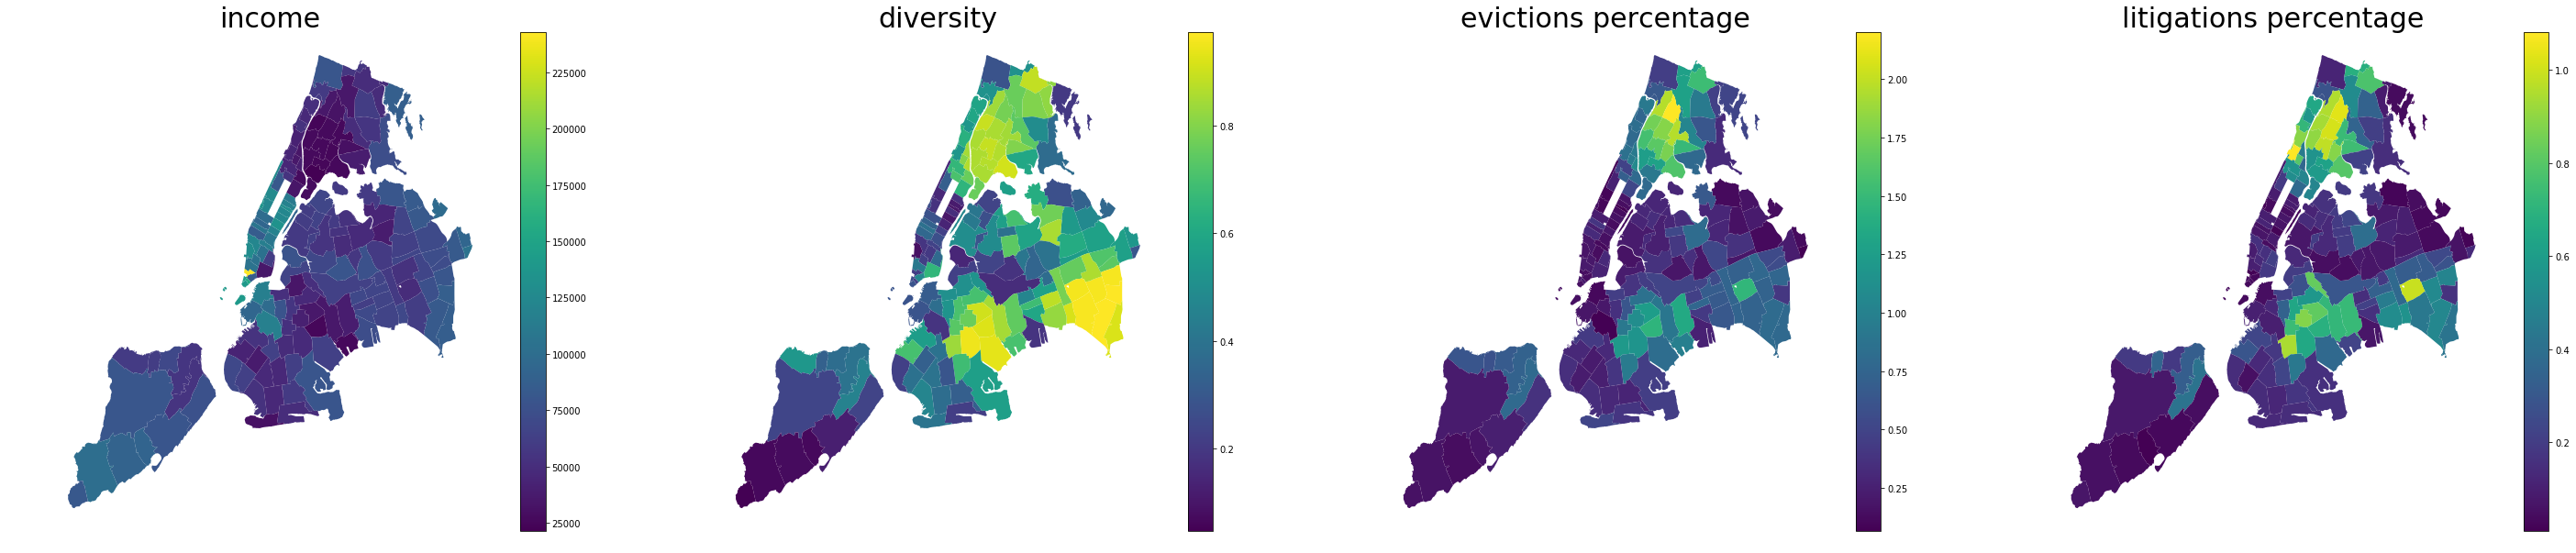

In [82]:
fig = pl.figure(figsize=(50,10))

ax1 = fig.add_subplot(141)
ax1.set_title('income', fontsize=30)
#converting income to float
final['income'] = final.income.astype(float)
final.plot(column='income', cmap='viridis', ax=ax1, legend=True)
ax1.axis('off')

ax2 = fig.add_subplot(142)
ax2.set_title('diversity', fontsize=30)
final.plot(column="non_whiteFraction", cmap='viridis', ax=ax2, legend=True)
ax2.axis('off')

ax3 = fig.add_subplot(143)
ax3.set_title('evictions percentage', fontsize=30)
final.plot(column="evic_pct", cmap='viridis', ax=ax3, legend=True)
ax3.axis('off')

ax4 = fig.add_subplot(144)
ax4.set_title('litigations percentage', fontsize=30)
final.plot(column="lit_pct", cmap='viridis', ax=ax4, legend=True)
ax4.axis('off');



# plot the distribution of evictions, litigations, and population diversity by zipcode

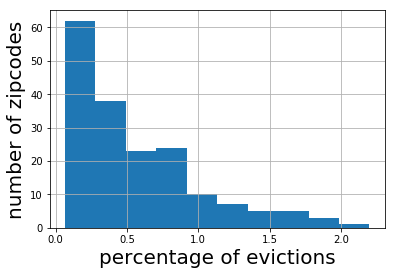

In [107]:
final.evic_pct.hist()
pl.xlabel("percentage of evictions", fontsize=20)
pl.ylabel("number of zipcodes", fontsize=20)
pl.title('Eviction')

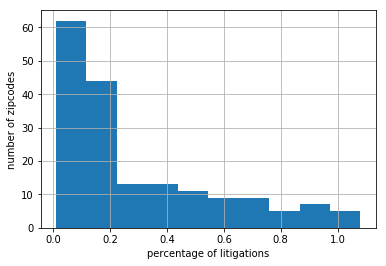

In [84]:
final.lit_pct.hist()
pl.xlabel("percentage of litigations")
pl.ylabel("number of zipcodes");

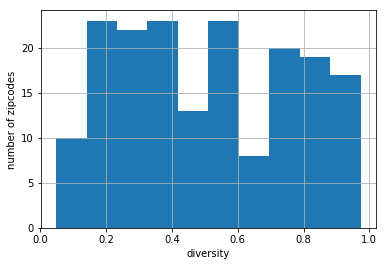

In [85]:
final.non_whiteFraction.hist()
pl.xlabel("diversity")
pl.ylabel("number of zipcodes");

# Statistical Tests

- KS test with eviction percentage
- KS test with litigation percentage

In [86]:
print ("KS test between eviction percentage by zipcode and a Gaussian distribution")
sp.stats.kstest((final.evic_pct - final.evic_pct.mean()) / final.evic_pct.std(), "norm")

KS test between eviction percentage by zipcode and a Gaussian distribution


KstestResult(statistic=0.14287413375449554, pvalue=0.0012385185581986757)

In [87]:
print ("KS test between number of litigation percentage by zipcode and a Gaussian distribution")
sp.stats.kstest((final.lit_pct - final.lit_pct.mean()) / final.lit_pct.std(), "norm")

KS test between number of litigation percentage by zipcode and a Gaussian distribution


KstestResult(statistic=0.1962797108840566, pvalue=1.7484855190375015e-06)

In [108]:
print ("KS test between number of non-white percentage by zipcode and a Gaussian distribution")
sp.stats.kstest((final.non_whiteFraction - final.non_whiteFraction.mean()) / final.non_whiteFraction.std(), "norm")

KS test between number of non-white percentage by zipcode and a Gaussian distribution


KstestResult(statistic=0.089762286090889876, pvalue=0.1068045236855597)

alpha = .05

In [116]:
print ("AD test between eviction percentage by zipcode and a normal distribution")
sp.stats.anderson((final.evic_pct - final.evic_pct.mean()) / final.evic_pct.std(), "norm")

AD test between eviction percentage by zipcode and a normal distribution


AndersonResult(statistic=7.8900483293109858, critical_values=array([ 0.564,  0.642,  0.77 ,  0.899,  1.069]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

In [117]:
print ("AD test between litigation percentage by zipcode and a normal distribution")
sp.stats.anderson((final.lit_pct - final.lit_pct.mean()) / final.lit_pct.std(), "norm")

AD test between litigation percentage by zipcode and a normal distribution


AndersonResult(statistic=10.428394413369006, critical_values=array([ 0.564,  0.642,  0.77 ,  0.899,  1.069]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

In [118]:
print ("AD test between non-white percentage by zipcode and a normal distribution")
sp.stats.anderson((final.non_whiteFraction - final.non_whiteFraction.mean()) / final.non_whiteFraction.std(), "norm")

AD test between non-white percentage by zipcode and a normal distribution


AndersonResult(statistic=2.5942775346734948, critical_values=array([ 0.564,  0.642,  0.77 ,  0.899,  1.069]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

# Measuring correlation between evictions/litigations and diversity

Evictions vs diversity

In [120]:
print ("Test of correlation between non-white percentage and eviction percentage")
sp.stats.pearsonr(final.non_whiteFraction, final.evic_pct)

Correlation test between non-white percentage and eviction percentage


(0.72901372072328852, 8.696231270035005e-31)

Litigations vs diversity

In [121]:
print ("Test of correlation between non-white percentage and litigation percentage")
sp.stats.pearsonr(final.non_whiteFraction, final.lit_pct)

Test of correlation between non-white percentage and litigation percentage


(0.71141258894529447, 9.1985820670814594e-29)

# Maps

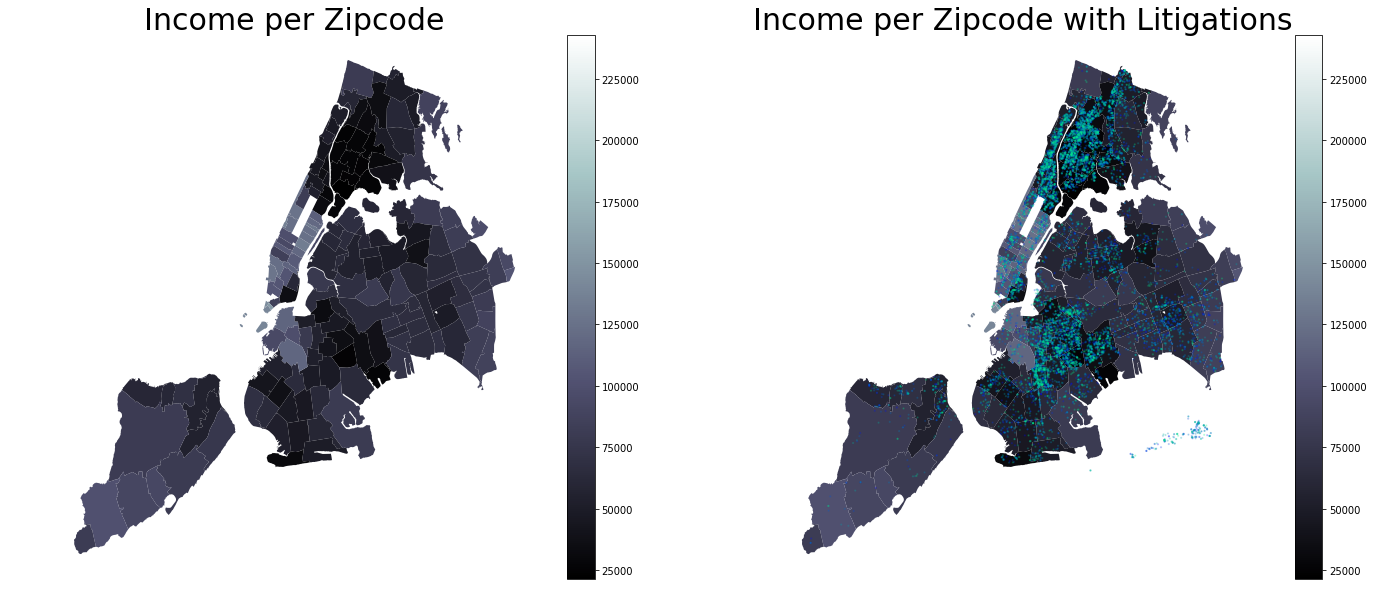

In [105]:
fig = pl.figure(figsize=(50,10))

ax3 = fig.add_subplot(143)
ax3.set_title('Income per Zipcode', fontsize=30)
final.plot(column="income", cmap='bone', ax=ax3, legend=True)
ax3.axis('off')

ax4 = fig.add_subplot(144)
ax4.set_title('Income per Zipcode with Litigations', fontsize=30)
final.plot(column="income", cmap='bone', ax=ax4, legend=True)
lit17.plot(ax=ax4, marker='.', c="CaseOpenDate", 
             markersize=6, cmap="winter", alpha=0.2);
ax4.axis('off');

Figure 1: Income by zipcode across five NYC boroughs. In both plots, darkers areas mean lower income. We see the highest incomes in Manhattan and parts of north Brooklyn. In the second plot, buildings that HPD has initiated action against are plotted in blue. While there are smattering of lawsuits in the higher income areas, the vast majority of the lawsuits are concentrated in two clusters: low-income areas of the Bronx and Brooklyn/Queens. 

(905410.75604293658, 1075212.538256279, 112386.35181947277, 280345.45402395498)

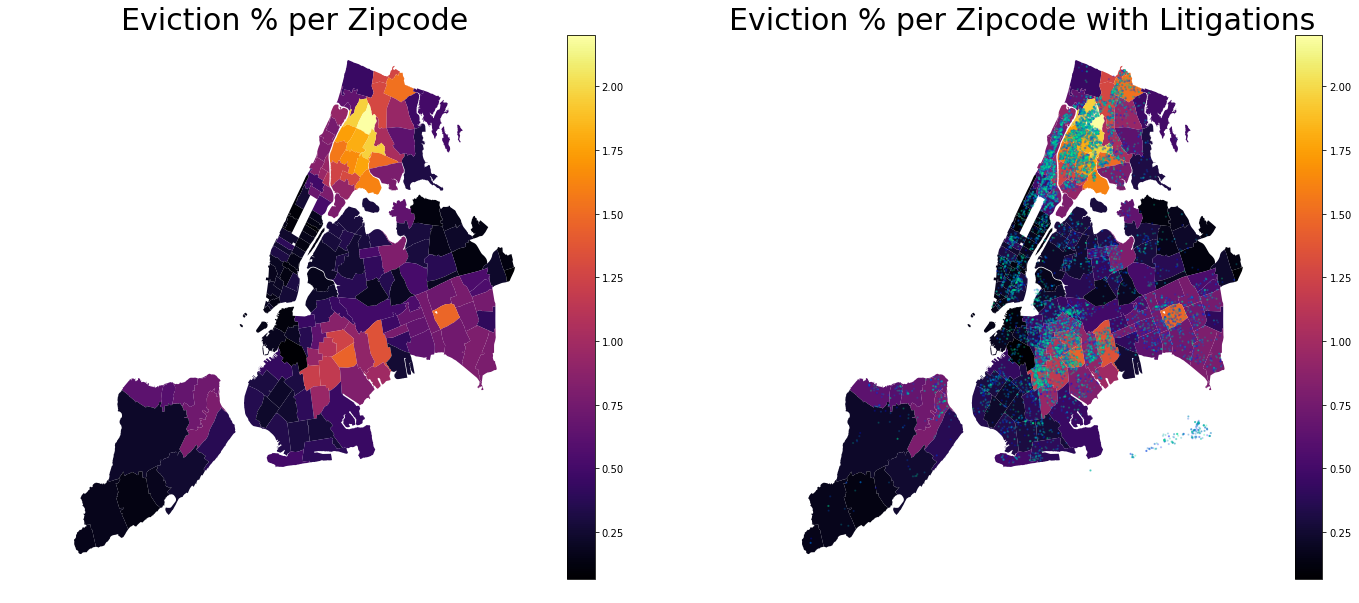

In [106]:
fig = pl.figure(figsize=(50,10))

ax1 = fig.add_subplot(141)
ax1.set_title('Eviction % per Zipcode', fontsize=30)
final.plot(column='evic_pct', cmap='inferno', ax=ax1, legend=True)
ax1.axis('off')

ax2 = fig.add_subplot(142)
ax2.set_title('Eviction % per Zipcode with Litigations', fontsize=30)
final.plot(column='evic_pct', cmap='inferno', ax=ax2, legend=True)
lit17.plot(ax=ax2, marker='.', c="CaseOpenDate", 
             markersize=6, cmap="winter", alpha=0.2);
ax2.axis('off')



Figure 2: Eviction as a percentage of total units per zip code. In both plots, lighter areas indicate a higher eviction rate. Eviction is the highest in the Bronx and nearly double the lower Manhattan rate. Portions of eastern Brooklyn and Queens, which are gentrifying, have high eviction rates as well. In the second plot, properties that HPD has initiated action against are plotted in blue. As with the plots above, we see that there is much overlap between high eviction areas and lawsuits. 